In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.externals import joblib
import numpy as np
import random
from random import randint
import os
#Popularity model
#Collaborative filtering
#

In [2]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import dump

In [67]:
def get_dataset(offline=True,dataset=None):
    
    if offline:
        if dataset=='Original': #the full 2 000000 dataset without spotify ids
            song_df = pd.read_csv(r'datasets/cf_dataset.csv',index_col=0)
        if dataset=='Edit':
            song_df =pd.read_csv(r'datasets/full_df.csv',index_col=0)

        
    else:
        triplets_file = 'The /10000.txt'
        songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

        song_df_1 = pd.read_table(triplets_file,header=None)
        song_df_1.columns = ['user_id', 'song_id', 'listen_count']

        #Read song  metadata
        song_df_2 =  pd.read_csv(songs_metadata_file)

        song_df_1.columns = ['user_id', 'song_id', 'listen_count']
        #Merge the two dataframes above to create input dataframe for recommender systems
        song_df = pd.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

    
    return song_df

df = get_dataset(dataset='Edit')

C:\Users\johan\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
len(df['song_id'].unique()) #7759 unique songs

7759

In [5]:
len(df['user_id'].unique()) #75951 unique users

75951

In [6]:
def overwrite():
    song_df.to_csv('cf_dataset.csv')

NameError: name 'song_df' is not defined

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550217 entries, 0 to 1550216
Data columns (total 21 columns):
user_id             1550217 non-null object
song_id             1550217 non-null object
listen_count        1550217 non-null int64
title               1550217 non-null object
release             1550217 non-null object
artist_name         1550217 non-null object
year                1550217 non-null int64
raw_ratings         1550217 non-null int64
queery              1550217 non-null object
ids                 1550217 non-null object
filter_que          1550217 non-null object
danceability        1550217 non-null float64
acousticness        1550217 non-null float64
energy              1550217 non-null float64
instrumentalness    1550217 non-null float64
key                 1550217 non-null float64
liveness            1550217 non-null float64
loudness            1550217 non-null float64
mode                1550217 non-null float64
tempo               1550217 non-null float64
v

In [7]:
df.head()

,user_id,song_id,listen_count,title,release,artist_name,year,raw_ratings,queery,ids,...,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,tempo,valence
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
1,930d2be6c85315d72cab9823ec0f7bfe7e477794,SOBBMDR12A8C13253B,1,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,1,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
2,41c12ce05f18b757d9257e5ad4f8303b4b8a8758,SOBBMDR12A8C13253B,66,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,20,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
3,f8611810514c93d57bb846aa0b5e0410d9730a14,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
4,5968a59e582f434a223b3786cd51c9f4690b38d4,SOBBMDR12A8C13253B,6,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,6,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914


In [68]:
counts = df['user_id'].value_counts()
large = counts[counts>10]
df1 = df.copy()
df1.set_index('user_id',inplace=True)
df1 = df1.loc[large.index,:]
df1.reset_index(inplace=True)
df=df1
len(df)

1347089

In [108]:
len(df.user_id.unique())

42288

In [106]:
len(df)

1347089

In [9]:
song_group = df.groupby(['title']).agg({'listen_count':'count'}).reset_index()
grouped_sum = song_group['listen_count'].sum()
song_group['Perc'] = song_group['listen_count'].div(grouped_sum)*100
df.agg()
song_group.sort_values(['listen_count','title'],ascending=[0,1],inplace=True)

#song_group.merge(df,on='title')
song_group.head(10)

TypeError: aggregate() missing 1 required positional argument: 'func'

### Checking the listen count for the songs

(array([7.157e+03, 1.210e+02, 5.200e+01, 1.600e+01, 1.100e+01, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([  48. ,  746.4, 1444.8, 2143.2, 2841.6, 3540. , 4238.4, 4936.8,
        5635.2, 6333.6, 7032. ]),
 <a list of 10 Patch objects>)

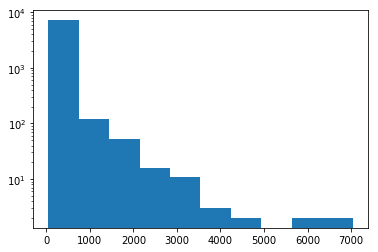

In [63]:
plt.hist(song_group.listen_count,log=True)

In [45]:
song_group.reset_index(inplace=True)
song_group.listen_count.sum()

1550217

In [11]:
df.head()

,user_id,song_id,listen_count,title,release,artist_name,year,raw_ratings,queery,ids,...,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,tempo,valence
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
1,930d2be6c85315d72cab9823ec0f7bfe7e477794,SOBBMDR12A8C13253B,1,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,1,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
2,41c12ce05f18b757d9257e5ad4f8303b4b8a8758,SOBBMDR12A8C13253B,66,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,20,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
3,f8611810514c93d57bb846aa0b5e0410d9730a14,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
4,5968a59e582f434a223b3786cd51c9f4690b38d4,SOBBMDR12A8C13253B,6,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,6,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914


In [ ]:
fig,ax= plt.subplot()
ax.hist(x=df['listen_count'],log=True, histtype='bar',label='Listen Count distribution')

ax.title('Listen Count Distribution')
ax.xlabel('Listen Count')
ax.ylabel('Number of users (Log)')
fig.show()

In [117]:
x=0
y= 0
for i in range(1,12):
    if i>10:
        mask = df.listen_count>=i
    else:
        mask = df.listen_count==i
    x+=len(df[mask])
    y+=len(df[mask])/tot
    print(f'{i} : {len(df[mask])}')
    print(f'{len(df[mask])/tot}')
print(tot,x,y)   

1 : 772651
0.5735708628011957
2 : 212960
0.15808903494869306
3 : 97110
0.07208877809855177
4 : 55920
0.04151173382011136
5 : 59516
0.044181193670202935
6 : 30161
0.02238976043899104
7 : 20404
0.015146734922488417
8 : 14888
0.01105197949059045
9 : 11068
0.008216235155954803
10 : 12043
0.008940018068590865
11 : 60368
0.044813668584629526
1347089 1347089 0.9999999999999999


In [112]:
tot =len(df)

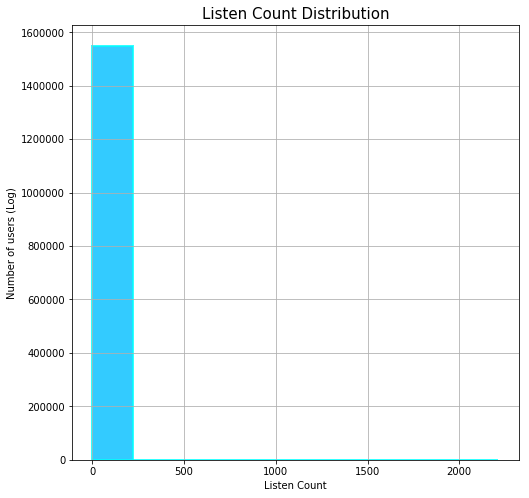

In [77]:
plt.figure(figsize=(8,8)) #change your figure size as per your desire here
n,bins,patch = plt.hist(df['listen_count'],color='deepskyblue',log=False,
                        alpha=0.8, label='Value', edgecolor='aqua', linewidth=2)
plt.title('Listen Count Distribution',fontdict={'fontsize':15})
plt.xlabel('Listen Count')
plt.ylabel('Number of users (Log)')
plt.grid()
plt.savefig(r'listen_count.png')
plt.show()


(array([772651., 212960.,  97110.,  55920.,  59516.,  30161.,  20404.,
         14888.,  11068.,  72411.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

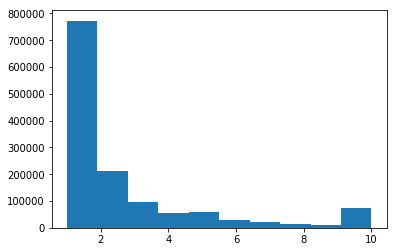

In [69]:
ndf = df.copy()
#mask = ndf.raw_ratings>1
#ndf=ndf[mask]
ndf['raw_ratings']= np.minimum(ndf['listen_count'],10)

plt.hist(ndf['raw_ratings'])#log=True)

### Set upper bound to 10

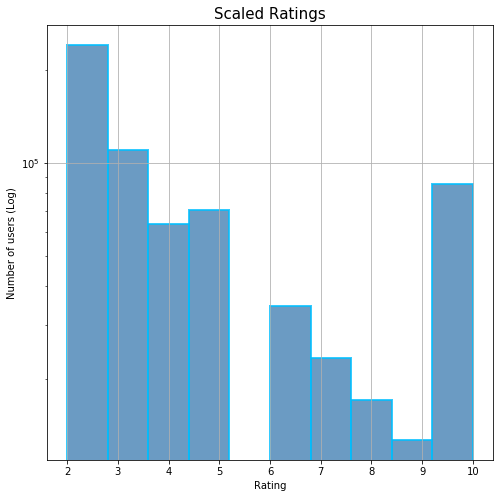

In [54]:
plt.figure(figsize=(8,8)) #change your figure size as per your desire here
n,bins,patch = plt.hist(ndf['raw_ratings'],color='steelblue',log=True,
                        alpha=0.8, label='Value', edgecolor='deepskyblue', linewidth=2)
plt.title('Scaled Ratings',fontdict={'fontsize':15})
plt.xlabel('Rating')
plt.ylabel('Number of users (Log)')
plt.grid()
plt.savefig(r'rating_hist.png')
plt.show()

In [55]:
ndf.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,raw_ratings,queery,ids,...,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,tempo,valence
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
2,41c12ce05f18b757d9257e5ad4f8303b4b8a8758,SOBBMDR12A8C13253B,66,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,10,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
3,f8611810514c93d57bb846aa0b5e0410d9730a14,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,2,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
4,5968a59e582f434a223b3786cd51c9f4690b38d4,SOBBMDR12A8C13253B,6,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,6,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914
6,ed789db32c9ccb59fb75e04a2b923b0f4777ae07,SOBBMDR12A8C13253B,3,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,3,Entre Dos Aguas artist:Paco De Lucia album:Fla...,spotify:track:3Fgk17TfdjXWFroJy29pXH,...,0.458,0.933,0.657,0.878,4.0,0.0842,-12.02,0.0,102.45,0.914


In [20]:
def save_save():
    ndf.to_csv(r'datasets\user_data_with_ratings.csv')

In [ ]:
print('hello')

In [ ]:
#Popular Recommender
def popular(data):
    dat = data.copy()
    dat.sort
popular(ndf)

# SVD

## Vanilla SVD

In [76]:
class SVDbuilder():
    """
    Function to build and train an SVD model for the collaborative filtering.
    
    
    The following functions are available:
    - data(datafarme,sample=False,sample_size=1000) - Create dataset and choose if sample
    - builder(self,*args) - build the algo, pass in agrs if you want any specs
    - load_model(name)
    - save_model(name)
    - Gridsearch(data,params,target='rmse')
    - fitting(gridsearch=False,full_set=False,dataframe=None)
    - get_info()
    - plot_atr()
    
    You can access:
    data
    algo
    best_model
    best_params
    """
    def __init__(self,algotype):
        self.svdT = algotype
    def data(self,dataframe,sample=False,sample_size=10000):
        reader = Reader(rating_scale=(1,10))
        if sample:
            dataframe = dataframe.sample(n=sample_size,random_state=0)
        self.data = Dataset.load_from_df(dataframe[['user_id','ids','raw_ratings']],reader)
        self.train,self.test = train_test_split(self.data,test_size=0.25)
    
    def builder(self,params=None,*args):
        if self.svdT =='vanilla':
            if args:           
                self.algo= SVD(params)
            else:
                self.algo=SVD()
        else:
            if args:           
                self.algo= SVDpp(args)
            else:
                self.algo=SVDpp()
    def load_model(self,name):
        _, loaded_algo = dump.load(name)
        self.algo = loaded_algo
    def save_model(self,name):
        # Dump algorithm and reload it.
        file_name = os.path.expanduser(name)
        dump.dump(file_name, algo=self.algo)
    
   
    def Gridsearch(self,params,target='rmse'):
        start= time.time()
        if self.svdT =='vanilla':
            self.gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
        else:
            self.gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3) 
        
        self.gs.fit(self.data)
        print(self.gs.best_score['rmse'])

        # combination of parameters that gave the best RMSE score
        
        print(self.gs.best_params['rmse'])
        self.best_model = self.gs.best_estimator['rmse']

        print('Time ',time.time()-start)
        
    def fitting(self,gridsearch=False,full_set=False,dataframe=None):
        start= time.time()
        if gridsearch:
            if full_set:
                Dataset.load_from_df(dataframe[['user_id','song_id','raw_ratings']],reader)
                self.train,self.test = train_test_split(data,test_size=0.25)
            
            self.algo = self.best_model
            self.algo.fit(self.train)
        else:
            self.algo.fit(self.train)
        
        self.pred = self.algo.test(self.test)
        print('Time ',time.time()-start)
    def get_info(self):
        x= self.algo
        preds= x.test(self.test)
        dd = {'Factors':[x.n_factors],
             'Epochs':[x.n_epochs],
             'Init Mean':x.init_mean,
             'Init Std': x.init_std_dev,             
              'Root MSE': accuracy.rmse(preds),
              'MSE':accuracy.mse(preds),
              'Mean average sqr':accuracy.mae(preds),
              'Fraction of Concordant Pairs':accuracy.fcp(preds)
             #'Regularization rate':x.reg_all,
             #'Learning rate':x.lr_all,
             }
        self.atr=pd.DataFrame.from_dict(data=dd)
        return self.atr
    def plot_atr(self):
        x=self.algo
        if self.svdT =='vanilla':
            stuff = [x.pu,x.qi,x.bu,x.bi]
        else:
            stuff = [x.pu,x.qi,x.yj,x.bu,x.bi]
            
        fig,axs = plt.subplots(len(stuff),figsize=(10,10))
        fig.suptitle('Model Attributes')
        
        
        for i,k in enumerate(stuff):
            axs[i].plot(k)
        
        

In [206]:
SVDbuilder

__main__.SVDbuilder

In [77]:
model1 = SVDbuilder('vanilla')
model1.data(ndf,sample=True)
model1.builder()
model1.fitting()

Time  0.422914981842041


In [78]:
model1.get_info()

RMSE: 2.4570
MSE: 6.0370
MAE:  1.7845
FCP:  0.4805


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,100,20,0,0.1,2.457033,6.037009,1.784518,0.48053


## Gridsearch for optimal parameters

In [79]:
param_grid = {'n_epochs': [15,20,25], 'lr_all': [0.002,0.003, 0.005],
              'reg_all': [0.4,0.5,0.6]}
model1.Gridsearch(param_grid)

2.451394670011396
{'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.6}
Time  36.458884954452515


In [80]:
model1.fitting(gridsearch=True)

Time  0.8547792434692383


In [81]:
model1.get_info()

RMSE: 2.4565
MSE: 6.0344
MAE:  1.7817
FCP:  0.4595


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,100,25,0,0.1,2.456495,6.034366,1.781676,0.459459


In [62]:
len(ndf)

659904

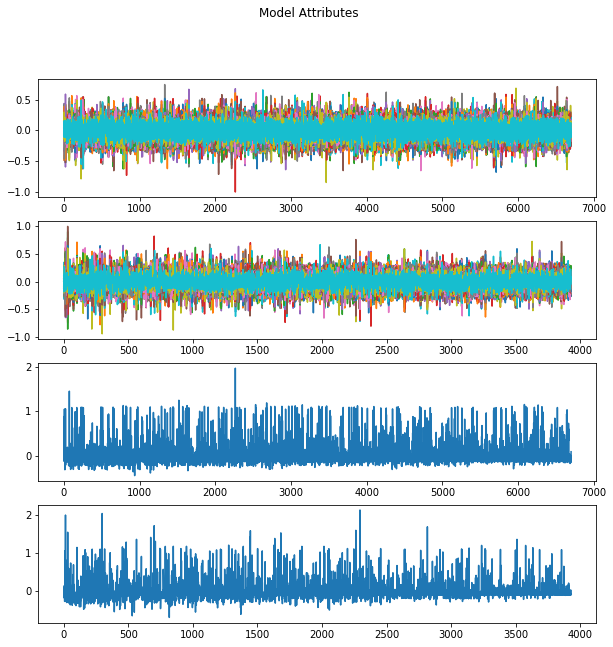

In [24]:
model1.plot_atr()

## Train the full dataset on optimal parameters and save the model

In [82]:
params= model1.gs.best_params['rmse']

In [83]:
model2 = SVDbuilder('vanilla')
model2.data(ndf,sample=False)
model2.builder(params)

In [84]:
model2.fitting()

Time  71.3339364528656


In [85]:
model2.get_info()

RMSE: 2.1846
MSE: 4.7727
MAE:  1.4755
FCP:  0.5678


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,100,20,0,0.1,2.184641,4.772655,1.475476,0.567835


In [17]:
preds = model2.algo.test(model2.test)

In [18]:
from surprise import accuracy
from collections import defaultdict
accuracy.rmse(preds)

RMSE: 2.4824


2.4823771003263366

In [69]:
model2.get_info()

RMSE: 2.5181
MSE: 6.3409
MAE:  1.9928
FCP:  0.5487


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,100,20,0,0.1,2.518113,6.340893,1.992823,0.548703


In [86]:
trainset =model2.algo.trainset

In [89]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df1 = pd.DataFrame(preds, columns=['uid', 'iid', 'rui', 'est', 'details'])
df1['Iu'] = df1.uid.apply(get_Iu)
df1['Ui'] = df1.iid.apply(get_Ui)
df1['err'] = abs(df1.est - df1.rui)


In [120]:
df1.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,4916d6f17cfa295f26c048b590621b8f33873a93,spotify:track:7eM88DF4yL4hpNnB6oJLnD,7.0,3.782364,{'was_impossible': False},8,46,3.217636
1,6f74b021cce5a9ee7a455e7f0ef4802bf498a23b,spotify:track:1Jx69b09LKTuBQxkEiFfVX,2.0,4.194529,{'was_impossible': False},47,88,2.194529
2,b1d8c13e91a65c10dc1b849b50e85a621af967a3,spotify:track:0E56lu4IOGOhygjIPC2r1r,10.0,4.180888,{'was_impossible': False},42,999,5.819112
3,5eac3949f62154f58867e68259c1deeb74c17003,spotify:track:3pEG4UmUXDLikXR0kWuNJH,6.0,3.170929,{'was_impossible': False},14,113,2.829071
4,f5d1809812524991f107d871319cc9ef171c4a28,spotify:track:2tP2rytUFVm6lhCznfLbv6,8.0,5.352406,{'was_impossible': False},22,179,2.647594


In [90]:
best_predictions2 = df1.sort_values(by='err')[:10].copy()
worst_predictions2 = df1.sort_values(by='err')[-10:].copy()

In [22]:
best_predictions1.to_csv('best_pred_CB_2_10.csv')
best_predictions1

,uid,iid,rui,est,details,Iu,Ui,err
16328,9ea3eafa48e73855fdecc165d3dc29dab64cbb46,spotify:track:5j6LS93cEIPNvkLZzAl1eK,10.0,10.0,{'was_impossible': False},27,49,0.0
95201,4c6426c9c734c23ec0c35154437fc132b862068c,spotify:track:2kSJrtoGIJ6u0L9OvKLJQJ,10.0,10.0,{'was_impossible': False},34,46,0.0
95091,d4c56211650ea452bff8377c69d380ddb4d705bb,spotify:track:0bTlXQJzw4ddaLQPJ4rGS2,10.0,10.0,{'was_impossible': False},59,2240,0.0
139977,a5f2de267eb3f3ed05ca7203f6b230a9e6805a14,spotify:track:75JFxkI2RXiU7L9VXzMkle,10.0,10.0,{'was_impossible': False},28,1171,0.0
65714,4e0b1f81b5201b8e46859b49dd71ab945366d40d,spotify:track:2XMywzsDdvIYO1WZYltvci,10.0,10.0,{'was_impossible': False},30,104,0.0
99648,b769e88d29aa4cd307dba66407ed54260a227a3b,spotify:track:5Mv6UlwDRX7eIUmWj5BA0q,10.0,10.0,{'was_impossible': False},55,41,0.0
109198,21fe97e9f2fd4aa4cd11db08c9683f5bb910b66b,spotify:track:71cYkGMbhkWXHkvc8VZ8ps,10.0,10.0,{'was_impossible': False},41,943,0.0
108821,a515ac8b40e82b0b7ad9191c5440319a848f9612,spotify:track:4w8bpxe4Qqy07Bzpuwc9SF,10.0,10.0,{'was_impossible': False},22,173,0.0
99433,abaf265b7dc7d19732cde4e55e04a1ae65514e03,spotify:track:5itKmzRJnapQRAfoqXAuSp,10.0,10.0,{'was_impossible': False},60,391,0.0
122744,46474cad92820165fa5a866b708df6e26f1e8eda,spotify:track:4WM22pqXRZkcdrp7alhjsv,10.0,10.0,{'was_impossible': False},21,389,0.0


In [93]:
from collections import Counter
def user_plot(iid,title,name=None,save=False):
    
    counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid(iid)]])
    x = pd.DataFrame.from_dict(
    counter, orient='index')
    x.reset_index(drop=False,inplace=True)
    x.sort_values(by='index',inplace=True)
    x.set_index('index',inplace=True)
    #x = pd.DataFrame.from_dict(
     #   counter, orient='index').plot(kind='bar', legend=False)
    x.plot(kind='bar',legend=False)
    #plt.bar(x)
    plt.xlabel('Rating value')
    plt.ylabel('Number of users')
    plt.title(f'Users listening patterns: {title}')
    if save:
        plt.savefig(rf'plots\{name}_CF_pr1.png')

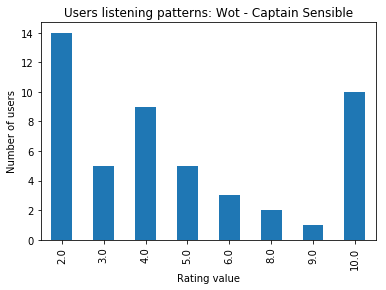

In [59]:
iid='spotify:track:5j6LS93cEIPNvkLZzAl1eK'
title='Wot - Captain Sensible'
user_plot(iid=iid,name='best',title=title,save=True)

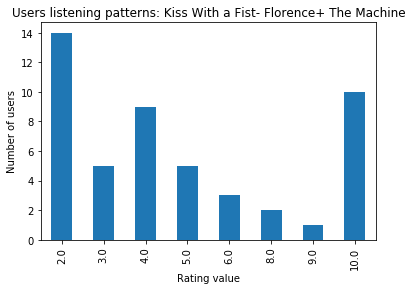

In [60]:
iid2='spotify:track:0jv5OcbvTUHgO8FgHhya8b'
user_plot(iid=iid2,name='worst',title='Kiss With a Fist- Florence+ The Machine',save=True)

In [23]:
worst_predictions1.to_csv('worst_CD_2_10.csv')
worst_predictions1

,uid,iid,rui,est,details,Iu,Ui,err
19798,15c7d74a3c1afa2110591713283efa0bbe14c2e9,spotify:track:0jv5OcbvTUHgO8FgHhya8b,10.0,1.463539,{'was_impossible': False},30,477,8.536461
28484,1aa4fd215aadb160965110ed8a829745cde319eb,spotify:track:793jTClDbqmxFme8QUl0JE,10.0,1.458685,{'was_impossible': False},171,110,8.541315
14337,7a7dc4aec09a72c616d04da1d6944cd392ee68de,spotify:track:0COqiPhxzoWICwFCS4eZcp,10.0,1.414952,{'was_impossible': False},71,653,8.585048
89351,55aec6fdfa7eae657f91f5941a1bb6a12b9dc023,spotify:track:4vp2J1l5RD4gMZwGFLfRAu,10.0,1.397227,{'was_impossible': False},40,777,8.602773
131386,870f1779c978274f4ab14ea139a79695c897baea,spotify:track:2ffmPvnKZQqAOAEUo5Klpu,10.0,1.344526,{'was_impossible': False},52,1177,8.655474
121663,6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d,spotify:track:5mSVJjVzZEoVrg6amF8udl,10.0,1.344082,{'was_impossible': False},201,79,8.655918
21167,51a95eaf5e69b1ca8e416ceff9c1a1cec995fc1c,spotify:track:11IzgLRXV7Cgek3tEgGgjw,10.0,1.328270,{'was_impossible': False},43,332,8.671730
90817,6f1702dd4bdfa1f7aace6064ca75d5921f993767,spotify:track:3rGgubo6wsk2X59XMYnZL6,10.0,1.302073,{'was_impossible': False},116,130,8.697927
29992,1f2f182fde1f4bc8d2262639c51be73b5d8555b1,spotify:track:4lwavw59UjXUPJZtKNdFYp,10.0,1.008608,{'was_impossible': False},18,959,8.991392
98547,6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d,spotify:track:0nCAVzknkzRXRgB6LhRv04,10.0,1.000000,{'was_impossible': False},201,164,9.000000


In [ ]:
titles= ndf[['ids','title']].copy()
titles.rename(columns={'ids':'iid'},inplace=True)
best_predictions2.iid

In [99]:

#best_predictions2=best_predictions2.merge(titles,on='iid')
#titles.head()
#best_predictions2.to_csv('best_pred_CB_1.csv')

best_predictions2

,uid,iid,rui,est,details,Iu,Ui,err
16328,9ea3eafa48e73855fdecc165d3dc29dab64cbb46,spotify:track:5j6LS93cEIPNvkLZzAl1eK,10.0,10.0,{'was_impossible': False},29,96,0.0
95201,4c6426c9c734c23ec0c35154437fc132b862068c,spotify:track:2kSJrtoGIJ6u0L9OvKLJQJ,10.0,10.0,{'was_impossible': False},48,63,0.0
95091,d4c56211650ea452bff8377c69d380ddb4d705bb,spotify:track:0bTlXQJzw4ddaLQPJ4rGS2,10.0,10.0,{'was_impossible': False},87,3524,0.0
139977,a5f2de267eb3f3ed05ca7203f6b230a9e6805a14,spotify:track:75JFxkI2RXiU7L9VXzMkle,10.0,10.0,{'was_impossible': False},34,2591,0.0
65714,4e0b1f81b5201b8e46859b49dd71ab945366d40d,spotify:track:2XMywzsDdvIYO1WZYltvci,10.0,10.0,{'was_impossible': False},37,156,0.0
99648,b769e88d29aa4cd307dba66407ed54260a227a3b,spotify:track:5Mv6UlwDRX7eIUmWj5BA0q,10.0,10.0,{'was_impossible': False},58,63,0.0
109198,21fe97e9f2fd4aa4cd11db08c9683f5bb910b66b,spotify:track:71cYkGMbhkWXHkvc8VZ8ps,10.0,10.0,{'was_impossible': False},53,1976,0.0
108821,a515ac8b40e82b0b7ad9191c5440319a848f9612,spotify:track:4w8bpxe4Qqy07Bzpuwc9SF,10.0,10.0,{'was_impossible': False},32,290,0.0
99433,abaf265b7dc7d19732cde4e55e04a1ae65514e03,spotify:track:5itKmzRJnapQRAfoqXAuSp,10.0,10.0,{'was_impossible': False},62,877,0.0
122744,46474cad92820165fa5a866b708df6e26f1e8eda,spotify:track:4WM22pqXRZkcdrp7alhjsv,10.0,10.0,{'was_impossible': False},29,896,0.0


In [117]:
###### a = [53,468,61,171,268,814,81,118,104,244]
a = [113,178,42,145,70,22,21,118,130,11]
np.mean(a)

85.0

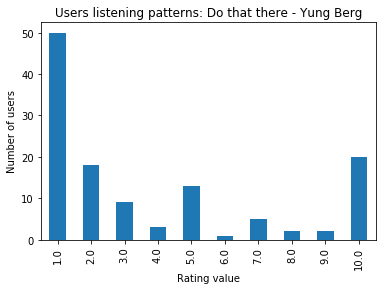

In [109]:

user_plot(iid='spotify:track:2CR62nxWDw8ZRmJLCpm5PD',title='Do that there - Yung Berg',save=True,name='Dothat_1_CB')

In [136]:
best_predictions1


,uid,iid,rui,est,details,Iu,Ui,err
0,dee6d7fcd869b969d209333513f965c8d4788994,spotify:track:6wUvHjoklTF6qgSZf9XWcM,1.0,1.0,{'was_impossible': False},31,206,0.0
301313,9daff407510fba46f2ddf46fbde9c84f1cb41608,spotify:track:5g8SFYkcNwvQge426KN8D4,1.0,1.0,{'was_impossible': False},43,102,0.0
112946,e29c3680bb3724d2d26bf395dd6db1bf91cc271a,spotify:track:7y4DV5fyumFO1FtCY91DEi,1.0,1.0,{'was_impossible': False},20,113,0.0
112975,431322cf25248f21da3d9a18ddf3216abd10938f,spotify:track:619bPJZXSzqYi5vysR51Sa,1.0,1.0,{'was_impossible': False},67,204,0.0
112977,be958a41e8435ea8cd531b0038dca8c216b2b804,spotify:track:5BgRSqd7xAhEfWgA9opde9,1.0,1.0,{'was_impossible': False},104,147,0.0
112981,29bce3ce70f3e22e4a8c305314e7400517a96ec8,spotify:track:6YBBmPBI2LZRG18k5NfcLX,1.0,1.0,{'was_impossible': False},72,850,0.0
17578,1fb479471a2b80b07c2d22b8e5b86adc9b87a353,spotify:track:0Om9WAB5RS09L80DyOfTNa,1.0,1.0,{'was_impossible': False},59,606,0.0
112994,4f0b45c639d272610c1745fe77650d70396c234e,spotify:track:4u6gJZKuSbGbcgIEkhlyjb,1.0,1.0,{'was_impossible': False},48,150,0.0
113002,6de6f52e02c361439e362f453405bada7e0b8fe0,spotify:track:64Ei3OCnT9OosQfjNz6enh,1.0,1.0,{'was_impossible': False},29,264,0.0
113004,0245d8e12bfabebff65bb2b0830d08892980ab1a,spotify:track:68K0qD0VDqdm0eWXsGqnvM,1.0,1.0,{'was_impossible': False},18,68,0.0


In [116]:
#worst_predictions2.to_csv('worst_pred_CB_1.csv')
worst_predictions2

,uid,iid,rui,est,details,Iu,Ui,err
19798,15c7d74a3c1afa2110591713283efa0bbe14c2e9,spotify:track:0jv5OcbvTUHgO8FgHhya8b,10.0,1.463539,{'was_impossible': False},67,960,8.536461
28484,1aa4fd215aadb160965110ed8a829745cde319eb,spotify:track:793jTClDbqmxFme8QUl0JE,10.0,1.458685,{'was_impossible': False},333,199,8.541315
14337,7a7dc4aec09a72c616d04da1d6944cd392ee68de,spotify:track:0COqiPhxzoWICwFCS4eZcp,10.0,1.414952,{'was_impossible': False},176,1318,8.585048
89351,55aec6fdfa7eae657f91f5941a1bb6a12b9dc023,spotify:track:4vp2J1l5RD4gMZwGFLfRAu,10.0,1.397227,{'was_impossible': False},108,1647,8.602773
131386,870f1779c978274f4ab14ea139a79695c897baea,spotify:track:2ffmPvnKZQqAOAEUo5Klpu,10.0,1.344526,{'was_impossible': False},69,2318,8.655474
121663,6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d,spotify:track:5mSVJjVzZEoVrg6amF8udl,10.0,1.344082,{'was_impossible': False},306,257,8.655918
21167,51a95eaf5e69b1ca8e416ceff9c1a1cec995fc1c,spotify:track:11IzgLRXV7Cgek3tEgGgjw,10.0,1.328270,{'was_impossible': False},62,645,8.671730
90817,6f1702dd4bdfa1f7aace6064ca75d5921f993767,spotify:track:3rGgubo6wsk2X59XMYnZL6,10.0,1.302073,{'was_impossible': False},226,416,8.697927
29992,1f2f182fde1f4bc8d2262639c51be73b5d8555b1,spotify:track:4lwavw59UjXUPJZtKNdFYp,10.0,1.008608,{'was_impossible': False},59,1901,8.991392
98547,6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d,spotify:track:0nCAVzknkzRXRgB6LhRv04,10.0,1.000000,{'was_impossible': False},306,537,9.000000


In [115]:
worst_predictions2.Iu.agg('mean')

171.2

In [119]:
from collections import defaultdict

from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


#data = Dataset.load_builtin('ml-100k')
kf = KFold(n_splits=5)
#algo = SVD()

for trainset, testset in kf.split(model2.data):
    alg = model2.algo.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.8449507776407108
0.5942498496555255
0.846969587109766
0.5961904708502896
0.8440813090581256
0.5940768421605569
0.8467662833397758
0.590735563330894
0.8439140023825611
0.5940552658137498


In [122]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
top_n=get_top_n(preds,n=10)
# Print the recommended items for each user
uuid = '6d625c6557df84b60d90426c0116138b617b9449'
#print(uuid, [iid for (iid, _) in user_ratings])
for user_ratings in top_n.items():
    print(uuid, [iid for (iid, _) in user_ratings])

ValueError: too many values to unpack (expected 2)

In [52]:
model3.get_info()

RMSE: 3.2303
MSE: 10.4351
MAE:  1.8992
FCP:  0.5483


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,100,20,0,0.1,3.230347,10.435141,1.899211,0.548286


## SVD ++

### ++ takes implicit ratings into account
#### Implicit ratings describes the fact that a user u rated item j regardless of the rating value

In [16]:
svdpp_samp= SVDbuilder('svdpp')
svdpp_samp.data(ndf,sample=True)
svdpp_samp.builder()
svdpp_samp.fitting()

Time  0.7680873870849609


In [17]:
param_grid = {'n_epochs': [15,20,25], 'lr_all': [0.002,0.003, 0.005],
              'reg_all': [0.4,0.5,0.6]}
svdpp_samp.Gridsearch(param_grid)

3.44817961702091
{'n_epochs': 15, 'lr_all': 0.003, 'reg_all': 0.6}
Time  67.20089554786682


In [18]:
svdpp_samp.fitting(gridsearch=True)

Time  0.6696450710296631


In [19]:
svdpp_samp.get_info()

RMSE: 3.4917
MSE: 12.1922
MAE:  2.1712
FCP:  0.4658


,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,20,15,0,0.1,3.491735,12.192214,2.171233,0.465753


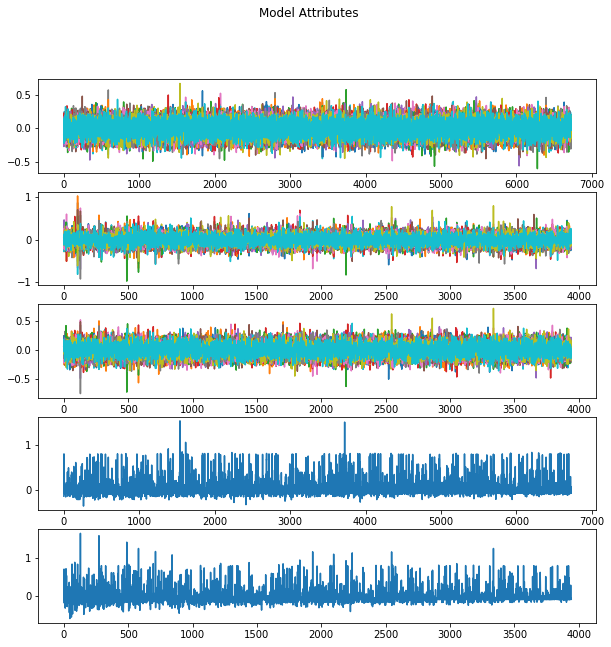

In [29]:
svdpp_samp.plot_atr()

In [20]:
svdpp_samp.atr

,Factors,Epochs,Init Mean,Init Std,Root MSE,MSE,Mean average sqr,Fraction of Concordant Pairs
0,20,15,0,0.1,3.491735,12.192214,2.171233,0.465753


## Train the full dataset on optimal parameters and save the model

In [23]:
params2 = svdpp_samp.gs.best_params['rmse']

In [9]:
svdpp1 = SVDbuilder('svdpp')
svdpp1.data(ndf,sample=False)
svdpp1.builder()


In [10]:
print('hello')

hello


In [ ]:
svdpp1.fitting()

In [ ]:
svdpp1.get_info()

In [ ]:
svdpp1.atr

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
#svdpp1.fitting(gridsearch=True,full_set=True,dataframe=ndf)
#svdpp1.save_model('svdpp2')

# Previous code

In [34]:
start = time.time()
param_grid = {'n_epochs': [15,20,25], 'lr_all': [0.002,0.003, 0.005],
              'reg_all': [0.4,0.5,0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(gs.data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
print(time.time()-start)

NameError: name 'data' is not defined

In [25]:
gs.cv_results

{'split0_test_rmse': array([3.46956038, 3.46886513, 3.46908695, 3.46492746, 3.46518026,
        3.46588462, 3.46174036, 3.46301033, 3.46325756, 3.46575156,
        3.46681201, 3.46657368, 3.46219616, 3.46345902, 3.46476663,
        3.46206769, 3.46291327, 3.46291395, 3.46409587, 3.46523656,
        3.4656658 , 3.46208049, 3.46182911, 3.46212835, 3.46327972,
        3.46348987, 3.46324858]),
 'split1_test_rmse': array([3.53052776, 3.52987029, 3.52977682, 3.52841528, 3.52859508,
        3.52915461, 3.52873527, 3.52899538, 3.52958019, 3.52841397,
        3.52924147, 3.52976972, 3.52928983, 3.52792363, 3.52983581,
        3.52926465, 3.5298111 , 3.529795  , 3.52894334, 3.52921379,
        3.52952869, 3.52911746, 3.52895721, 3.52886852, 3.53266671,
        3.53350206, 3.53120078]),
 'split2_test_rmse': array([3.55916403, 3.55936925, 3.55885673, 3.5573727 , 3.55768523,
        3.55731361, 3.55550504, 3.55686436, 3.55502466, 3.55753831,
        3.55841482, 3.55730116, 3.55767244, 3.55601991, 

In [205]:
def vanSVD(train,test):
    algo = SVD()
    algo.fit(train)
    pred= algo.test(test)
    return algo,pred
svd_model,pred1 =vanSVD(train=train,test=test)
accuracy.rmse(pred1)

RMSE: 3.2765


3.2765339259585886

In [108]:
uid = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
sid = 'SOHRQZQ12A6D4F81D2'
svd_model.predict(uid,sid,verbose=True)

user: b80344d063b5ccb3212f76538f3d9e43d87dca9e item: SOHRQZQ12A6D4F81D2 r_ui = None   est = 2.76   {'was_impossible': False}


Prediction(uid='b80344d063b5ccb3212f76538f3d9e43d87dca9e', iid='SOHRQZQ12A6D4F81D2', r_ui=None, est=2.758888888888889, details={'was_impossible': False})

In [355]:
real= []
est = []
start =time.time()
for i,k in enumerate(pred2):
    real.append(k.r_ui)
    est.append(k.est)
print(time.time()-start)

0.3287515640258789


In [ ]:
real=np.array(real)
est = np.array(est)
diff = np.subtract(np.log(real),np.log(est))
plt.plot(diff)

### Try to predict a list of songs for a user that she hasn't heard before

In [60]:
from scipy.stats import kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
plt.style.use('seaborn')
#sns.kdeplot(real,est, cmap="Reds", shade=True)
#plt.title('Overplotting? Try 2D density graph', loc='left')

#### 2 ways of selecting dataframe without that user

In [229]:
class recommender():
    def __init__(self,data,model):
        self.user = None
        self.model = model
        self.df = data
    def get_user(self,test):
        if test: #just to test
            self.user = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
        else:
            ind = randint(0,len(self.data)-1) #get a random index
            self.user = self.data.loc[ind,'user_id']
            
            
    def recommend(self,sample=False): 
        #pick all the songs which the user has not listened to
        non_interacted_songs = self.df[self.df['user_id'] != self.user]
        songs = non_interacted_songs['song_id']
        if sample:
            sample_songs = songs.sample(n=100,random_state=10)
        
        songs = list(songs.unique()) 
        #since same song can come up for different users
        
        iids=[]
        scores=[]
        
        for k in songs:
            values = self.model.predict(self.user,k,verbose=False)
            iids.append(values.iid)
            scores.append(values.est)
        #
        d = {'song_id':iids,'score':scores}
        recs = pd.DataFrame(data=d)
        self.rec = recs.sort_values('score',ascending=False).reset_index(drop=True)
        

In [210]:
start= time.time()
user1 = recommender(data=ndf,model= svdpp_model)
user1.get_user(test=True)
user1.recommend(sample=False)
print(time.time()-start)

2.1708788871765137


In [226]:
recs = user1.rec
user1.rec.head()

,id,score
0,SOACBLB12AB01871C7,9.472962
1,SOWDNAY12A8C1354A4,7.948089
2,SOOGNOZ12AAF3B2936,7.815060
3,SOBFPJC12A58A7D1AB,7.379370
4,SORJICW12A8C13640D,7.271135


In [269]:
recs.head()

,song_id,score
0,SOACBLB12AB01871C7,9.472962
1,SOWDNAY12A8C1354A4,7.948089
2,SOOGNOZ12AAF3B2936,7.815060
3,SOBFPJC12A58A7D1AB,7.379370
4,SORJICW12A8C13640D,7.271135


In [274]:
songss= df[['song_id','title','artist_name']]
songss['song_id'] = songss.song_id.astype('str')
recs['song_id'] = recs.song_id.astype('str')
songss.head()

C:\Users\johan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,song_id,title,artist_name
0,SOAKIMP12A8C130995,The Cove,Jack Johnson
1,SOBBMDR12A8C13253B,Entre Dos Aguas,Paco De Lucia
2,SOBXHDL12A81C204C0,Stronger,Kanye West
3,SOBYHAJ12A6701BF1D,Constellations,Jack Johnson
4,SODACBL12A8C13C273,Learn To Fly,Foo Fighters


In [277]:
recs.info()
#type(recs.loc[0,'song_id'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
song_id    10000 non-null object
score      10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
songs = pd.read_csv('https://static.turi.com/datasets/millionsong/song_data.csv')
songs = songs[['song_id', 'title', 'artist_name']]
results = recs.join(songs,on='song_id', how='inner')
results.head()

In [7]:
from surprise import dump
def save_model(name,model):
    # Dump algorithm and reload it.
    file_name = os.path.expanduser(name)
    dump.dump(file_name, algo=model)
def load_model(file_name):
    _, loaded_algo = dump.load(file_name)
    return loaded_algo



In [ ]:
save_model(name='svdvanilla',model=svd_model)

In [10]:
svdpp= load_model(r'models/svdpp')

In [ ]:
# We now ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
assert predictions == predictions_loaded_algo
print('Predictions are the same')

# KNN
#### KNN could not handle more than 50000 observations, due to the size of the cosine matrix

In [99]:
from surprise import KNNBasic
sample = ndf.sample(n=30000,random_state=0)
data = Dataset.load_from_df(sample[['user_id','song_id','raw_ratings']],reader)
train,test = train_test_split(data,test_size=0.25)

In [100]:
def KNN(train,test):
    sim_options={'name':'msd',
                'user_based':True}
    algo = KNNBasic(sim_options=sim_options)#sim_options={'user_based':True})
    algo.fit(train)
    pred= algo.test(test)
    return algo,pred
#



model, pred =KNN(train=train,test=test)
accuracy.rmse(pred)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.4969


3.4969041721873553

In [101]:
accuracy.mse(pred)

MSE: 12.2283


12.228338789461333